In [1]:
import sys,os

RES_PATH = '../../../resources'
LIB_PATH = '../../../python_lib'

if not os.path.exists(RES_PATH):
    print( 'cannot find \COMPM080-Tutorials-2020\resources\, please update RES_PATH')
    exit(1)
else:
    print('found resources')

# append path 
sys.path.append(LIB_PATH) 
from geo_tools import rd_helper

import pyglet
pyglet.options['shadow_window'] = False

import pyrender
import numpy as np
import trimesh

import matplotlib
import matplotlib.pyplot as plt

from sklearn.neighbors import KDTree

found resources


In [48]:
mesh_fp = os.path.join(RES_PATH,'torus.obj')
assert os.path.exists(mesh_fp), 'cannot found:'+mesh_fp 
mm = trimesh.load(mesh_fp) 

surface_points = mm.sample(3000)#np.array(mm.vertices)
print(surface_points.shape)

(3000, 3)


C:\Users\prady\Anaconda3\lib\site-packages\matplotlib\collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


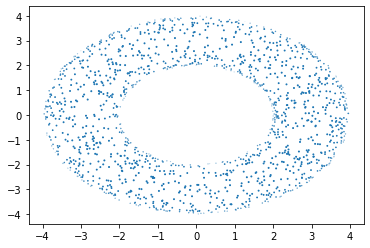

In [49]:
plt.scatter(surface_points[:,0],surface_points[:,1],surface_points[:,2])

# Least square based normal estimation

In [38]:
import numpy.linalg as la

def normalize_v3(arr):
    ''' Normalize a numpy array of 3 component vectors shape=(n,3) '''
    lens = np.sqrt( arr[:,0]**2 + arr[:,1]**2 + arr[:,2]**2 )
    arr[:,0] /= lens
    arr[:,1] /= lens
    arr[:,2] /= lens                
    return arr

def lstsq_plane_fitting(total, indices, k):
    normals=np.zeros((len(indices),3))
    curvatures=np.zeros(len(indices))
    #for point in range(25):
    for point in range(len(indices)):

        dots=np.zeros((k,3))
        
        for nei in range(k):
            loc=indices[point, nei]
            xyz=[total[loc,0], total[loc,1], total[loc,2]]
            dots[nei,:]=xyz
    
        (a, b, c),resid,rank,s = np.linalg.lstsq(dots[:,:3], np.ones_like(dots[:,2]))
        normal = (a, b, c)
        nn = np.linalg.norm(normal)
        normal = normal / nn

        normals[point,:]= normal[:3]
        if point%1000==0:
            print("Accomplishment of: "+str(point)+" points out of: "+str(len(indices)))
    return normals, curvatures

In [50]:
num_neighbours = 3
tree=KDTree(surface_points)
distances, indices =tree.query(surface_points, num_neighbours)


In [51]:
num_to_show=len(indices)

normals, precurv= lstsq_plane_fitting(surface_points, indices[:num_to_show], 3)
normal=normalize_v3(normals)


Accomplishment of: 0 points out of: 3000
Accomplishment of: 1000 points out of: 3000
Accomplishment of: 2000 points out of: 3000


C:\Users\prady\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [52]:
def create_vertex_normal_render_obj(surface_points, normals):
    p0 = surface_points#trimesh_obj.vertices.copy()
    p1 = surface_points + normals#trimesh_obj.vertex_normals*0.01
    
    edges_mesh = rd_helper.create_edges(p0,p1,no_vex=True)
    
    
    return edges_mesh

In [53]:

# create render objects
mobj = pyrender.Mesh.from_trimesh(mm)
vobj = create_vertex_normal_render_obj(surface_points, normals)


# add render objects into scene graph
scene = pyrender.Scene(ambient_light=0.4*np.array([1.0, 1.0, 1.0, 1.0]))

mesh_node=scene.add(mobj)
if vobj is not None:
    nv_node=scene.add(vobj)

# initial a context object
gctx={}

# record render objects
# gctx['mesh_node']=mesh_node
gctx['nv_node']=nv_node
gctx['show_mesh_node']=True
gctx['show_nv_node']  =True
gctx['scene']=scene
gctx['cur_scale']=1.0
gctx['cur_color']=np.array((0,255,0),dtype=np.uint8)

In [54]:

def run_gui(scene):    
    
    # call GUI
    v=pyrender.Viewer(scene, use_raymond_lighting=True)
    del v
    
run_gui(scene)

# PCA based normal estimation

In [4]:

def PreCoplaner(total, indices, k):
    normals=np.zeros((len(indices),3))
    curvatures=np.zeros(len(indices))
    #for point in range(25):
    for point in range(len(indices)):

        dots=np.zeros((k,3))
        
        for nei in range(k):
            loc=indices[point, nei]
            xyz=[total[loc,0], total[loc,1], total[loc,2]]
            dots[nei,:]=xyz
        mean=np.mean(dots,axis=0)
        
        #mean=np.mean(total[indices[point,:k],:],axis=0)
        data_adjust=dots-mean
        matrix = np.cov(data_adjust.T)
        eigenvalues, eigenvectors = np.linalg.eig(matrix)
        
        sort = (-eigenvalues).argsort()#[::-1]
        eigenvalues = eigenvalues[sort]
        curvature=abs(eigenvalues[2])/(abs(eigenvalues[0])+abs(eigenvalues[1])+abs(eigenvalues[2]))
        curvatures[point]=curvature
        eigenvectors = eigenvectors[:,sort]
        normal=eigenvectors[:,2]
        normals[point,:]= normal
        if point%1000==0:
            print("Accomplishment of: "+str(point)+" points out of: "+str(len(indices)))
    return normals, curvatures

In [55]:
num_neighbours = 20
tree=KDTree(surface_points)
distances, indices =tree.query(surface_points, num_neighbours)


In [56]:
num_to_show=len(indices)
normals, precurv= PreCoplaner(surface_points, indices[:num_to_show], 20)

normals=normalize_v3(normals)


Accomplishment of: 0 points out of: 3000
Accomplishment of: 1000 points out of: 3000
Accomplishment of: 2000 points out of: 3000


In [57]:
def create_vertex_normal_render_obj(surface_points, normals):
    p0 = surface_points#trimesh_obj.vertices.copy()
    p1 = surface_points + normals#trimesh_obj.vertex_normals*0.01
    edges_mesh = rd_helper.create_edges(p0,p1,no_vex=True)
    
    
    return edges_mesh

In [58]:

# create render objects
mobj = pyrender.Mesh.from_trimesh(mm)
vobj = create_vertex_normal_render_obj(surface_points, normals)


# add render objects into scene graph
scene = pyrender.Scene(ambient_light=0.4*np.array([1.0, 1.0, 1.0, 1.0]))

mesh_node=scene.add(mobj)
if vobj is not None:
    nv_node=scene.add(vobj)

# initial a context object
gctx={}

# record render objects
# gctx['mesh_node']=mesh_node
gctx['nv_node']=nv_node
gctx['show_mesh_node']=True
gctx['show_nv_node']  =True
gctx['scene']=scene
gctx['cur_scale']=1.0
gctx['cur_color']=np.array((0,255,0),dtype=np.uint8)

In [59]:

def run_gui(scene):    
    
    # call GUI
    v=pyrender.Viewer(scene, use_raymond_lighting=True)
    del v
    
run_gui(scene)